In [1]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d 'vijaykumar1799/face-mask-detection'


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/vijaykumar1799/face-mask-detection
License(s): CC0-1.0
 63% 140M/222M [00:00<00:00, 1.45GB/s]
100% 222M/222M [00:00<00:00, 946MB/s] 


In [2]:
import zipfile
with zipfile.ZipFile('/content/face-mask-detection.zip','r') as zip_ref:
  zip_ref.extractall("/content/dataset_org")

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B3,preprocess_input
import os

In [4]:
DIRECTORY= '/content/dataset_org/Dataset'

df_list = []

for lable in os.listdir(DIRECTORY):
  path = os.path.join(DIRECTORY,lable)
  for img in os.listdir(path):
    filepath = os.path.join(path,img)
    lable = lable

    df_list.append([filepath,lable])



In [5]:
df = pd.DataFrame(df_list,columns=['filepath','lable'])

In [6]:
from sklearn.model_selection import train_test_split
train_df,test_df = train_test_split(df,stratify=df['lable'],random_state=42)

In [7]:
train_data_gen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    zoom_range = 0.15
    )

test_data_gen = ImageDataGenerator(
    preprocessing_function = preprocess_input
)

train_generator = train_data_gen.flow_from_dataframe(
    train_df,
    x_col = 'filepath',
    y_col = 'lable',
    target_size = (224,224),
    class_mode = 'categorical',
    shuffle = True
)

test_generator = test_data_gen.flow_from_dataframe(
    test_df,
    x_col = 'filepath',
    y_col = 'lable',
    target_size = (224,224),
    class_mode = 'categorical',
    shuffle = False
)

Found 6736 validated image filenames belonging to 3 classes.
Found 2246 validated image filenames belonging to 3 classes.


In [8]:
from tensorflow.keras.layers import Dense,Input,Dropout,BatchNormalization,GlobalMaxPooling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model

base_model = EfficientNetV2B3(weights='imagenet', include_top = False, input_shape=(224,224,3))
base_model.trainable = False
inputs = Input(shape = (224,224,3))

x = base_model(inputs,training = False)
x = GlobalMaxPooling2D()(x)

x = Dense(128,activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(3,activation = 'softmax')(x)

model = Model(inputs,outputs)

52606240/52606240 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b3 (Functional)  │ (None, 7, 7, 1536)     │    12,930,622 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 1536)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,128,257 (50.08 MB)

 Trainable params: 197,379 (771.01 KB)

 Non-trainable params: 12,930,878 (49.33 MB)

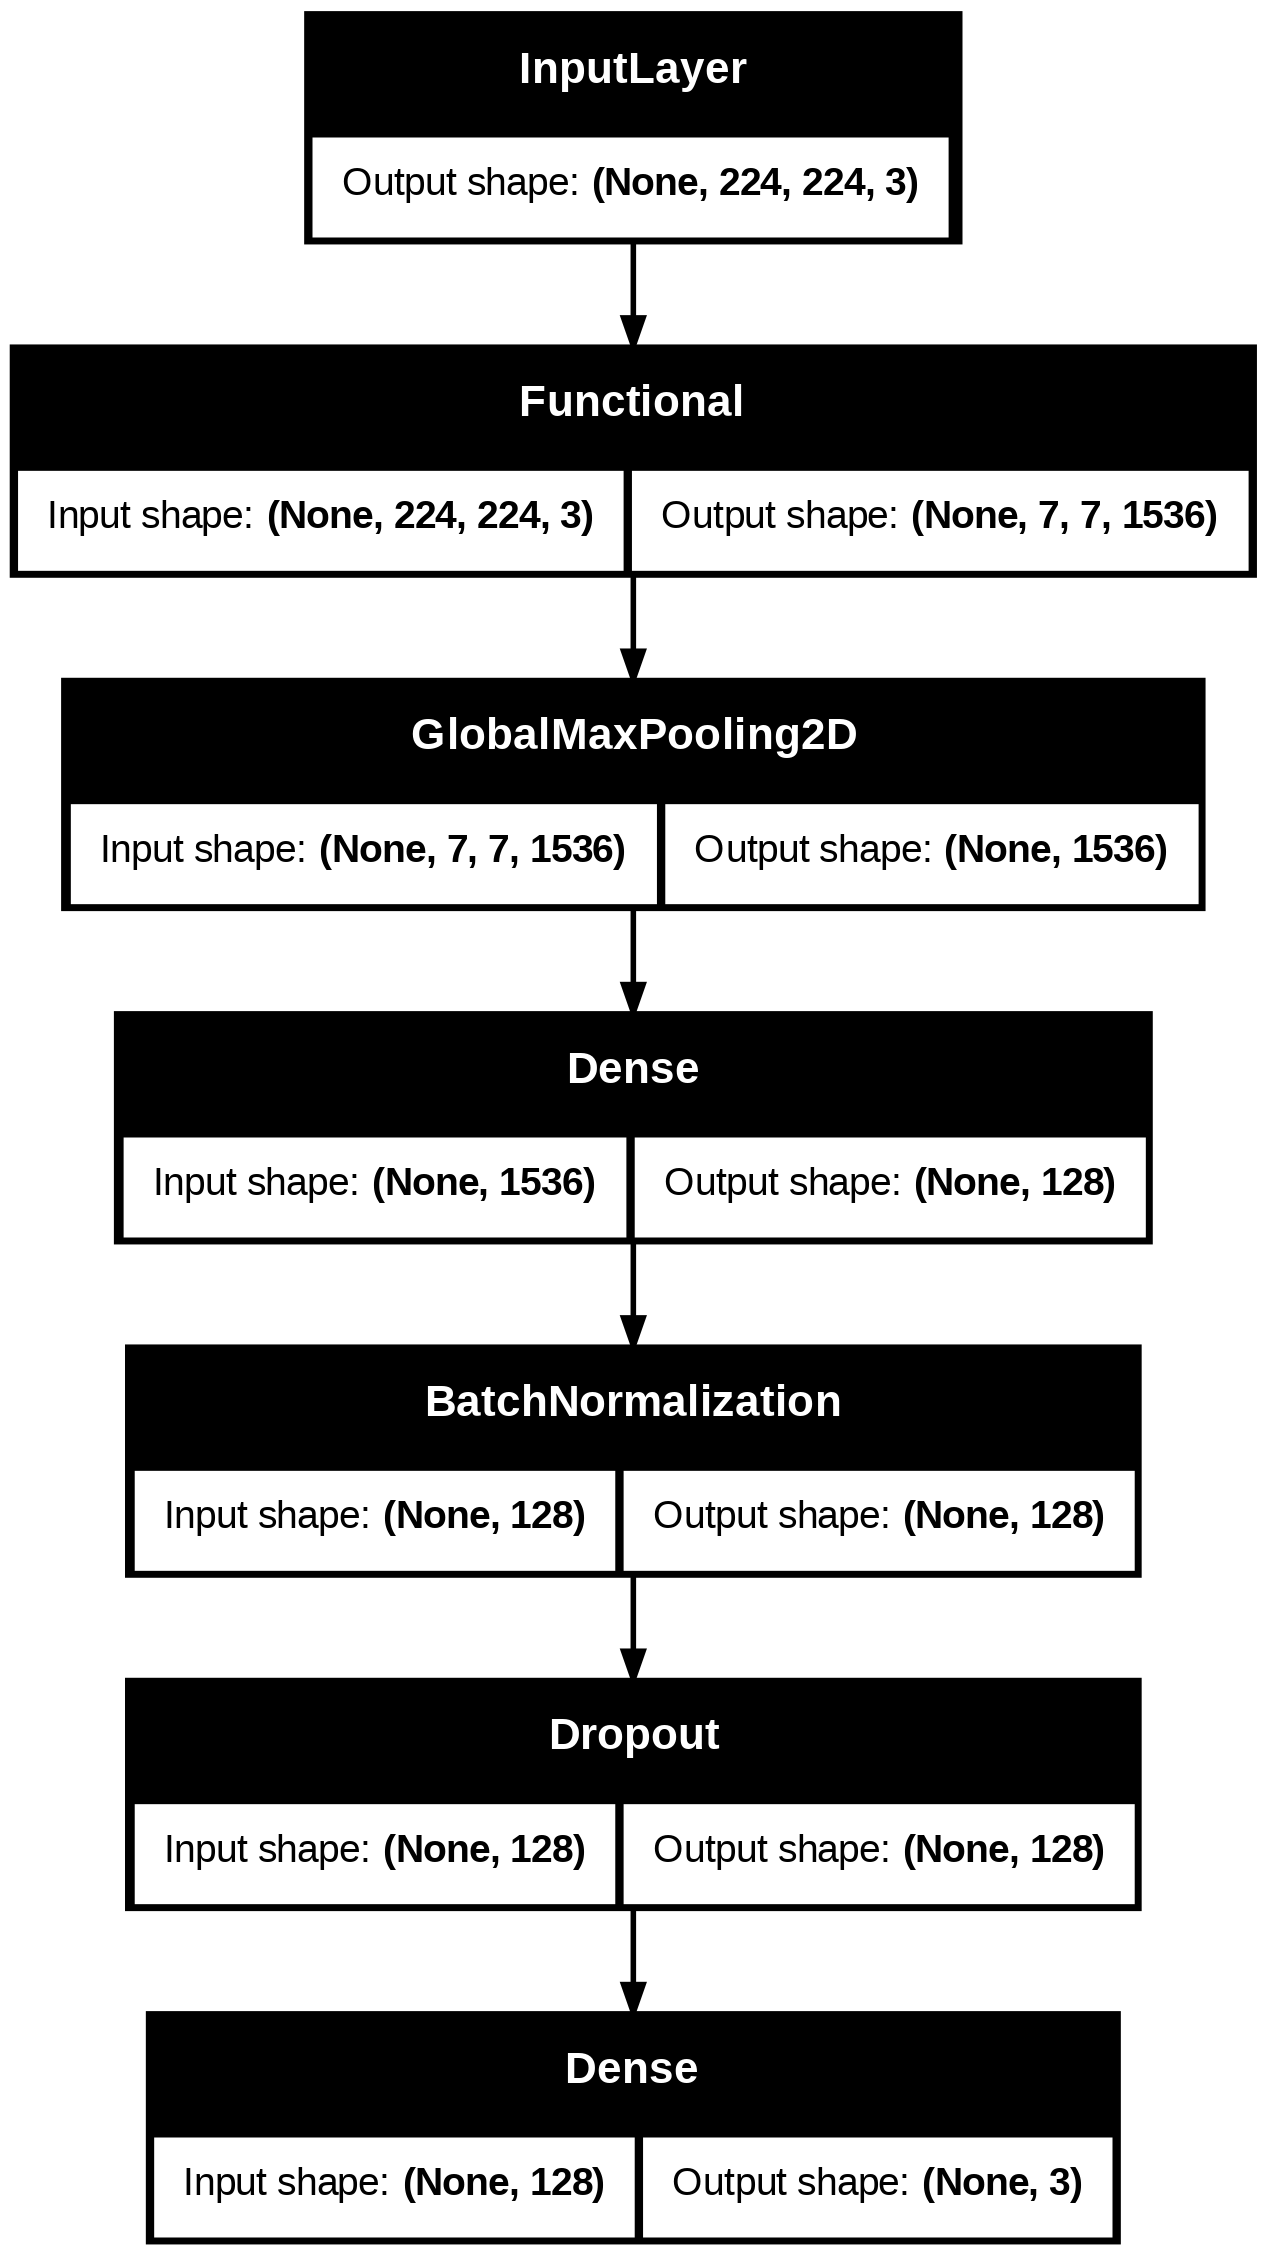

In [10]:
plot_model(model,show_shapes=True)

In [11]:
model.compile(optimizer='adam',loss = 'categorical_crossentropy', metrics=['accuracy'])

In [13]:
history = model.fit(train_generator,epochs=3,validation_data=test_generator,verbose=1)

Epoch 1/3
211/211 ━━━━━━━━━━━━━━━━━━━━ 86s 407ms/step - accuracy: 0.9405 - loss: 0.1577 - val_accuracy: 0.9720 - val_loss: 0.0839
Epoch 2/3
211/211 ━━━━━━━━━━━━━━━━━━━━ 142s 407ms/step - accuracy: 0.9615 - loss: 0.1242 - val_accuracy: 0.9733 - val_loss: 0.0784
Epoch 3/3
211/211 ━━━━━━━━━━━━━━━━━━━━ 86s 408ms/step - accuracy: 0.9578 - loss: 0.1274 - val_accuracy: 0.9773 - val_loss: 0.0684


In [18]:
model.save('mask_detection.keras')

In [17]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

# Path to a single test image
img_path = '/content/young-man-wearing-medical-mask-260nw-1770304052.webp'

# Load image, resize to model input
img = image.load_img(img_path, target_size=(224, 224))

# Convert to array and expand dims (batch size = 1)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Preprocess for EfficientNetV2
img_array = preprocess_input(img_array)

# Make prediction
pred = model.predict(img_array)  # shape = (1, 3)

# Apply softmax to interpret as probabilities
# (if your model already ends with softmax, this is optional)
probabilities = pred[0]  # shape = (3,)

# Map indices to class names
class_names = ['Mask_Incorrect', 'Mask', 'No_Mask']

# Find predicted class
predicted_index = np.argmax(probabilities)
predicted_class = class_names[predicted_index]

print("Predicted class:", predicted_class)
print("Class probabilities:", probabilities)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted class: Mask
Class probabilities: [7.142208e-05 9.999106e-01 1.801806e-05]
